In [67]:
#Import necessary dependencies or frameworks or libraries
from plotly import graph_objs as go;import copy; import datetime;import gc; gc.collect()
import numpy as np;import pandas as pd, os, gc;import seaborn as sns;from tqdm import tqdm; import missingno as msno
from sklearn.model_selection import KFold,cross_val_score,GroupKFold,RepeatedKFold,StratifiedKFold,GridSearchCV,cross_validate
import plotly.express as px;import math
from scipy import stats;import statsmodels.api as sm;from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time;import warnings;from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split; from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer; import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, log_loss;from sklearn.feature_selection import mutual_info_classif
import lightgbm as lgb;from sklearn import metrics; from scipy.optimize import minimize
from lightgbm import LGBMClassifier; from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')
from typing import List
import perfplot

In [68]:
#Data path & csv files name extension
data_path='/Users/DELL/Desktop/Hackhathons/Kowope/Data/'
train='Train.csv';test='Test.csv';submission ='SampleSubmission.csv'

In [69]:
#define some fxn to read the data set
def read_train():
    train_data =pd.read_csv(data_path + train)
    return train_data
def read_test():
    test_data =pd.read_csv(data_path + test)
    return test_data
def read_submission():
    sample_submission =pd.read_csv(data_path + submission)
    return sample_submission
#Assign defined fxns to variables
train = read_train();test=read_test();submission=read_submission()

In [70]:
test=test.copy()

In [71]:
test_id=test['Applicant_ID']

In [72]:
train['default_status']= train['default_status'].replace({'yes': 1,'no': 0})

In [73]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

In [74]:
#train['loans_behaviour']=train['form_field3'] - (train['form_field4'] +train['form_field5'])

In [75]:
train.drop(['Applicant_ID'], axis=1, inplace =True)
test.drop(['Applicant_ID'], axis=1, inplace =True)

In [76]:
features=['form_field1','form_field2'] #add field12

In [77]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

In [78]:
data['form_field28'].max()#- add value_counts to model #23

60772.0

In [79]:
data['Total_severity']=data['form_field3']+data['form_field4']+data['form_field5']
data['Total_loans_last2yrs']=data['form_field46']+data['form_field43']+data['form_field45']
data['Total _active credits']=data['form_field19']+data['form_field20']# or coconact
data['12-11']=data['form_field12']-data['form_field11']
data['17-18']=data['form_field17']-data['form_field18']
data['48/49']=data['form_field49']+data['form_field48']
data['Amount_paid_to_sum_due']=data['form_field13']-data['form_field12']
data['32/33']=data['form_field32']-data['form_field33']
data['14-13']=data['form_field14']-data['form_field13']
data['DX/DYAverage utilization']=data['form_field22']-data['form_field23']
data['Debt_to_income']=data['form_field13']/data['form_field14'] #try 12/14
data['Debt_to_income']=data['Debt_to_income'].round(2).astype(str) + '%'

In [80]:
def worthy_level(x):
    if x <= 3484:
        return 'less-worthy'
    else:
        return 'worthy'
data['worth_level']= data['form_field1'].map(worthy_level)

In [81]:
bins = [0, 100000, 500000, 1000000,100000000, 500000000, 1014471051]
labels = ['extremely_low','low', 'medium', 'high','semi_high', 'extreme high']
data['Binned income'] = pd.cut(data['form_field14'], bins=bins, labels=labels)

In [82]:
def aggregate_features(x,col_name):
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    return x  

In [83]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


In [84]:
bins = [0, 100000, 500000, 1000000,100000000, 500000000, 1014471051]
labels = ['extremely_low','low', 'medium', 'high','semi_high', 'extreme high']
data['Binned income'] = pd.cut(data['form_field14'], bins=bins, labels=labels)

In [85]:
train=data[data.default_status.notnull()].reset_index(drop=True)
test=data[data.default_status.isna()].reset_index(drop=True)

In [86]:
test=test.drop(['default_status'], axis=1)

In [87]:
import category_encoders as ce
oce = ce.OneHotEncoder(cols=['form_field47'])
hce = ce.TargetEncoder(cols=['Binned income','Debt_to_income','worth_level'],smoothing=40,min_samples_leaf=7)

In [88]:
X=train.drop(['default_status'], axis=1)
y=train.default_status

In [89]:
X = oce.fit_transform(X)
X = hce.fit_transform(X,y)
test = oce.transform(test)
test = hce.transform(test)

In [90]:
test=test.drop(['form_field47_2'], axis=1)
X=X.drop(['form_field47_2'], axis=1)

In [91]:
X.shape

(56000, 69)

In [92]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2001)#2001

In [93]:
param = { 
         'objective':'binary',
         'max_depth': 12,
         'learning_rate': 0.05, #try 0.07 and restack
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "metric": 'auc',
        'seed':1993,
    'num_boost_round':1000,
    'stratified':True,
         "verbose": 0}

In [94]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GroupKFold, train_test_split
    
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=20, random_state=1993, shuffle=True)#20
i=1

for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=LGBMClassifier(**param, random_state=188)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=50, early_stopping_rounds=300)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

Training until validation scores don't improve for 300 rounds
[50]	training's auc: 0.853605	valid_1's auc: 0.847653
[100]	training's auc: 0.871887	valid_1's auc: 0.865266
[150]	training's auc: 0.885961	valid_1's auc: 0.878841
[200]	training's auc: 0.897668	valid_1's auc: 0.890031
[250]	training's auc: 0.908278	valid_1's auc: 0.900772
[300]	training's auc: 0.917656	valid_1's auc: 0.909867
[350]	training's auc: 0.926297	valid_1's auc: 0.918535
[400]	training's auc: 0.933988	valid_1's auc: 0.926187
[450]	training's auc: 0.940557	valid_1's auc: 0.932918
[500]	training's auc: 0.946684	valid_1's auc: 0.938633
[550]	training's auc: 0.952318	valid_1's auc: 0.944094
[600]	training's auc: 0.958002	valid_1's auc: 0.949887
[650]	training's auc: 0.962167	valid_1's auc: 0.953906
[700]	training's auc: 0.966438	valid_1's auc: 0.958108
[750]	training's auc: 0.970099	valid_1's auc: 0.961938
[800]	training's auc: 0.973214	valid_1's auc: 0.965011
[850]	training's auc: 0.976004	valid_1's auc: 0.967923
[900

[800]	training's auc: 0.972919	valid_1's auc: 0.964222
[850]	training's auc: 0.975769	valid_1's auc: 0.967183
[900]	training's auc: 0.978445	valid_1's auc: 0.969707
[950]	training's auc: 0.980875	valid_1's auc: 0.972258
[1000]	training's auc: 0.983441	valid_1's auc: 0.975115
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.983441	valid_1's auc: 0.975115
err:  0.8326683694156133
Training until validation scores don't improve for 300 rounds
[50]	training's auc: 0.854111	valid_1's auc: 0.847947
[100]	training's auc: 0.872	valid_1's auc: 0.864721
[150]	training's auc: 0.886038	valid_1's auc: 0.877945
[200]	training's auc: 0.897984	valid_1's auc: 0.889388
[250]	training's auc: 0.908476	valid_1's auc: 0.899601
[300]	training's auc: 0.917844	valid_1's auc: 0.908541
[350]	training's auc: 0.926622	valid_1's auc: 0.917376
[400]	training's auc: 0.933911	valid_1's auc: 0.924234
[450]	training's auc: 0.940837	valid_1's auc: 0.931105
[500]	training's auc: 0.947303	valid_1's a

KeyboardInterrupt: 

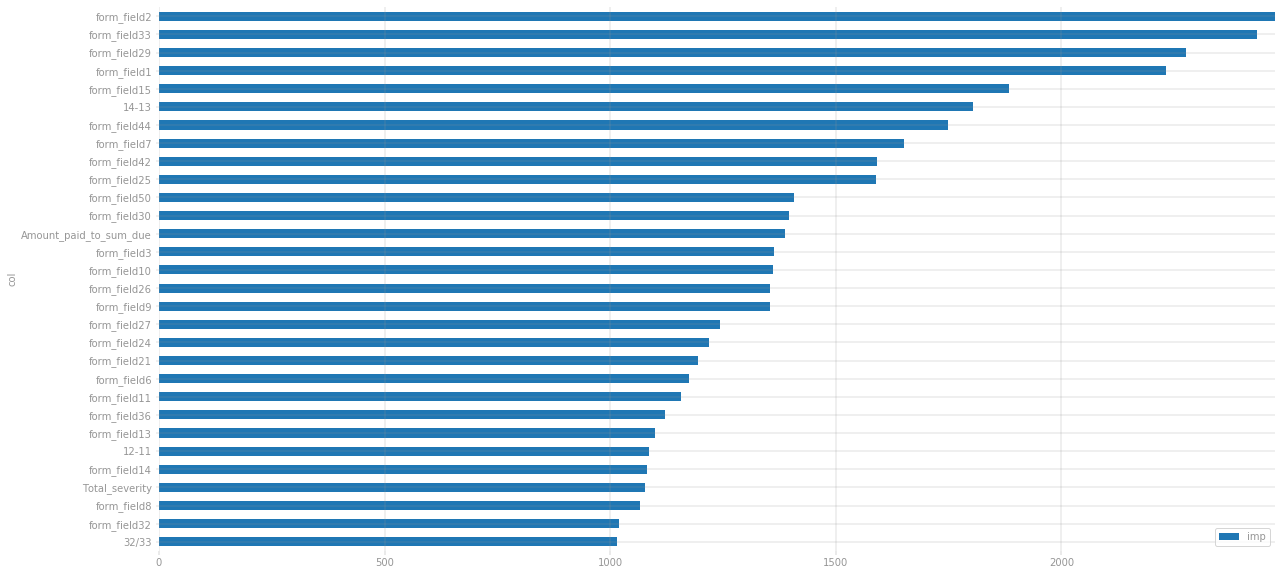

In [63]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')

In [64]:
d = {"Applicant_ID": test_id, 'default_status':np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Applicant_ID", 'default_status']]

In [65]:
test_predictions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.250080
1,Apcnt_1000048,0.159972
2,Apcnt_1000052,0.412304
3,Apcnt_1000076,0.788176
4,Apcnt_1000080,0.046363


In [66]:
test_predictions.to_csv('LGBM-X.csv', index=False)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  AdaBoostClassifier

In [63]:
model =  LogisticRegression(random_state=2001)
clf4 = AdaBoostClassifier(base_estimator =model, n_estimators=2000, learning_rate =0.05)

In [64]:
clf4.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=2001,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=0.05, n_estimators=2000, random_state=None)

In [65]:
p2 = clf4.predict_proba(test)[:, 1]

In [66]:
d = {"Applicant_ID": test_id, 'default_status':p2}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["Applicant_ID", 'default_status']]

In [67]:
test_predictions.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.498766
1,Apcnt_1000048,0.498487
2,Apcnt_1000052,0.499998
3,Apcnt_1000076,0.499772
4,Apcnt_1000080,0.498150


In [68]:
test_predictions.to_csv('ADA.csv', index=False)

In [70]:
X.columns

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field47_1', 'form_field48',
       'form_field49', 'form_field50', 'Total_severity',
       'Total_loans_last2yrs', 'Total _active credits', '12-11', '17-18',
       '48/49', 'Amount_

In [181]:
y=pd.DataFrame(data=y);y.head()

,default_status
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [182]:
train.tail()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,DX/DYAverage utilization,Debt_to_income,worth_level,Binned income,min_form_field1,max_form_field1,mean_form_field1,min_form_field2,max_form_field2,mean_form_field2
55995,3740.0,0.01730,0.0000,0.0000,0.0,770998.0,9637475.0,4047934.0,11641992.0,19910965.0,...,1662.15,0.54%,worthy,high,3740.0,3740.0,3740.0,0.01730,0.01730,0.01730
55996,3360.0,2.01145,0.6252,0.0000,0.0,-1.0,927765.0,-1.0,-1.0,1849306.0,...,13351.00,0.0%,less-worthy,high,3360.0,3360.0,3360.0,2.01145,2.01145,2.01145
55997,3500.0,0.76640,0.0000,0.0000,0.0,118645.0,3662435.0,3662435.0,3585024.0,704090.0,...,-10483.05,0.19%,worthy,high,3500.0,3500.0,3500.0,0.76640,0.76640,0.76640
55998,3280.0,0.05235,2.0916,2.2212,0.0,-1.0,3458599.0,-1.0,115533.0,3458599.0,...,0.00,0.0%,less-worthy,high,3280.0,3280.0,3280.0,0.05235,0.05235,0.05235
55999,3522.0,0.46930,0.0000,0.0000,0.0,98806.0,2053920.0,523983.0,14903368.0,5430440.0,...,0.00,0.25%,worthy,high,3522.0,3522.0,3522.0,0.46930,0.46930,0.46930


In [183]:
train=pd.concat([X,y], axis=1)

In [192]:
train_col = ['form_field1', 'form_field2',
             'form_field47_1', 'form_field48',
       'form_field49', 'form_field50', 'Total_severity',
       'Total_loans_last2yrs', 'Total _active credits', '12-11', '17-18',
       '48/49', 'Amount_paid_to_sum_due', '32/33', '14-13',
       'DX/DYAverage utilization', 'Debt_to_income', 'worth_level',
       'Binned income', 'min_form_field1', 'max_form_field1',
       'mean_form_field1', 'min_form_field2', 'max_form_field2',
       'mean_form_field2','form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46'
            ]

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GroupKFold
oof = np.zeros(len(X))
Target_name="default_status"
not_used_cols=[Target_name]
features_name=[ f for f in train_col if f not in not_used_cols]
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X, y, groups=X.form_field1) ):

    
    
    log_train = X.loc[idxT,features_name]
    log_test = X.loc[idxV,features_name]


    log_train_y = train['default_status'][idxT]
    log_test_y = train['default_status'][idxV]
 

    lr = RandomForestClassifier(random_state=7, n_estimators=2000, max_depth=6,class_weight='balanced',min_samples_split=10,min_samples_leaf=10)

    lr.fit(log_train,log_train_y)

    pred = lr.predict_proba(log_test)[:,1]
    oof[idxV] = pred

    print('Fold ', i)
    print (roc_auc_score(log_test_y, pred))
print(features_name)
print(roc_auc_score(y, oof))

Fold  0
0.8007900207900208
Fold  1
0.8248702729939585
Fold  2
0.811362433442302
Fold  3
0.8269035904136901
Fold  4
0.8244223670155623
Fold  5
0.8179873569245634
['form_field1', 'form_field2', 'form_field47_1', 'form_field48', 'form_field49', 'form_field50', 'Total_severity', 'Total_loans_last2yrs', 'Total _active credits', '12-11', '17-18', '48/49', 'Amount_paid_to_sum_due', '32/33', '14-13', 'DX/DYAverage utilization', 'Debt_to_income', 'worth_level', 'Binned income', 'min_form_field1', 'max_form_field1', 'mean_form_field1', 'min_form_field2', 'max_form_field2', 'mean_form_field2', 'form_field3', 'form_field4', 'form_field5', 'form_field6', 'form_field7', 'form_field8', 'form_field9', 'form_field10', 'form_field11', 'form_field12', 'form_field13', 'form_field14', 'form_field15', 'form_field16', 'form_field17', 'form_field19', 'form_field20', 'form_field21', 'form_field22', 'form_field23', 'form_field24', 'form_field25', 'form_field26', 'form_field27', 'form_field28', 'form_field29', '